In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [194]:
from covid19dh import covid19
world, src = covid19(verbose=False)

In [14]:
raw, src_raw = covid19(verbose=False) # debug purpose
len(raw.columns)

47

## Spain

In [15]:
world.head()

,id,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,...,iso_alpha_3,iso_alpha_2,iso_numeric,iso_currency,key_local,key_google_mobility,key_apple_mobility,key_jhu_csse,key_nuts,key_gadm
119977,0094b645,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA
119978,0094b645,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA
119979,0094b645,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA
119980,0094b645,2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA
119981,0094b645,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA


In [16]:
world.shape

(189239, 47)

In [17]:
world.columns

Index(['id', 'date', 'confirmed', 'deaths', 'recovered', 'tests', 'vaccines',
       'people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu', 'vent',
       'school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index',
       'administrative_area_level', 'administrative_area_level_1',
       'administrative_area_level_2', 'administrative_area_level_3',
       'latitude', 'longitude', 'population', 'iso_alpha_3', 'iso_alpha_2',
       'iso_numeric', 'iso_currency', 'key_local', 'key_google_mobility',
       'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_g

Kolumny które możemy odrzucić na samym początku:
 - id
 - hosp, icu, vent: zmienne mówiące o liczbie pacjentów w szpitalach w różnym stanie. Nie są celem naszej analizy, a same w sobie stanowią skutek liczby zachorowań i ewentualnie polityki danego kraju, a nie jakąkolwiek ich przyczynę.
 - economic_support_index: mówi o tym jakie wsparcie ekonomiczne dla obywateli zostało udzielone, nie ma wpływu na liczbę zachorowań
 - administrative_area_level_[1-3]: nazwa obszaru z którego zostały zebrane dane, przy analizie globalnej nie ma to znaczenia, przy analizie lokalnej zestaw danych zostanie zawężony na podstawie tych kolumn
 - latitude, longitude: podobnie do powyższego, same w sobie nie stanowią żadnej informacji
 - iso_alpha_3, iso_alpha_2, iso_numeric: nazwa kraju w postaci kodu, nieistotna
 - iso_currency: waluta, nie ma wpływu
 - key_*: zmienne będące identyfikatorami regionów administracyjnych w różnych formatach

In [18]:
spain = world[(world.administrative_area_level == 1) & (world.administrative_area_level_1 == 'Spain')]
spain = spain.reset_index(drop=True)

In [19]:
columns_to_drop = [
    'id',
    'hosp',
    'icu',
    'vent',
    'latitude',
    'longitude',
    'economic_support_index'
] + list(world.filter(regex='iso|administrative|key'))

spain = spain.drop(columns=columns_to_drop, axis=1)

In [195]:
columns_to_drop.remove('administrative_area_level_1')

world = world.drop(columns=columns_to_drop, axis=1)

In [156]:
print(world.shape, spain.shape)

(189239, 27) (784, 25)


Po usunięciu nieistotnych kolumn, udało się zredukować liczbę zmiennych z 47 do 26.

In [22]:
world_nulls = 100 * world.isnull().sum() / world.shape[0]
spain_nulls = 100 * spain.isnull().sum() / spain.shape[0]

pd.DataFrame({
    'World': world_nulls,
    'Spain': spain_nulls
})

,World,Spain
administrative_area_level_1,0.000000,NaN
cancel_events,20.006975,5.727924
confirmed,8.696410,1.193317
contact_tracing,20.030226,6.443914
containment_health_index,20.053477,6.443914
date,0.000000,0.000000
deaths,17.160311,4.892601
elderly_people_protection,20.043437,6.443914
facial_coverings,19.880152,6.443914
gatherings_restrictions,20.004862,6.443914


Widzimy, że charakterystyka braków danych różni się w zależności od tego, czy rozważamy dane globalnie czy tylko dla Hiszpanii.

Widzimy, że wszystkie kolumny poza datą zawierają braki danych, w różnym stopniu.
- Dla wszystkich zmiennych opisujących poziom restrykcji, liczba braków danych oscyluje w okolicy 20%
- Dla zmiennej odpowiadającej za populację w danym kraju mamy 0.44% braków. Ponieważ wstępne przypuszczenia są takie, że może być to zmienna dosyć istotna w kontekście przewidywania bezwględnej liczby przypadków, zdecydowałem się usunąć obserwacje z brakujacymi danymi z tej kolumny.
- ## Co zrobić z brakującymi wartościami w confirmed?

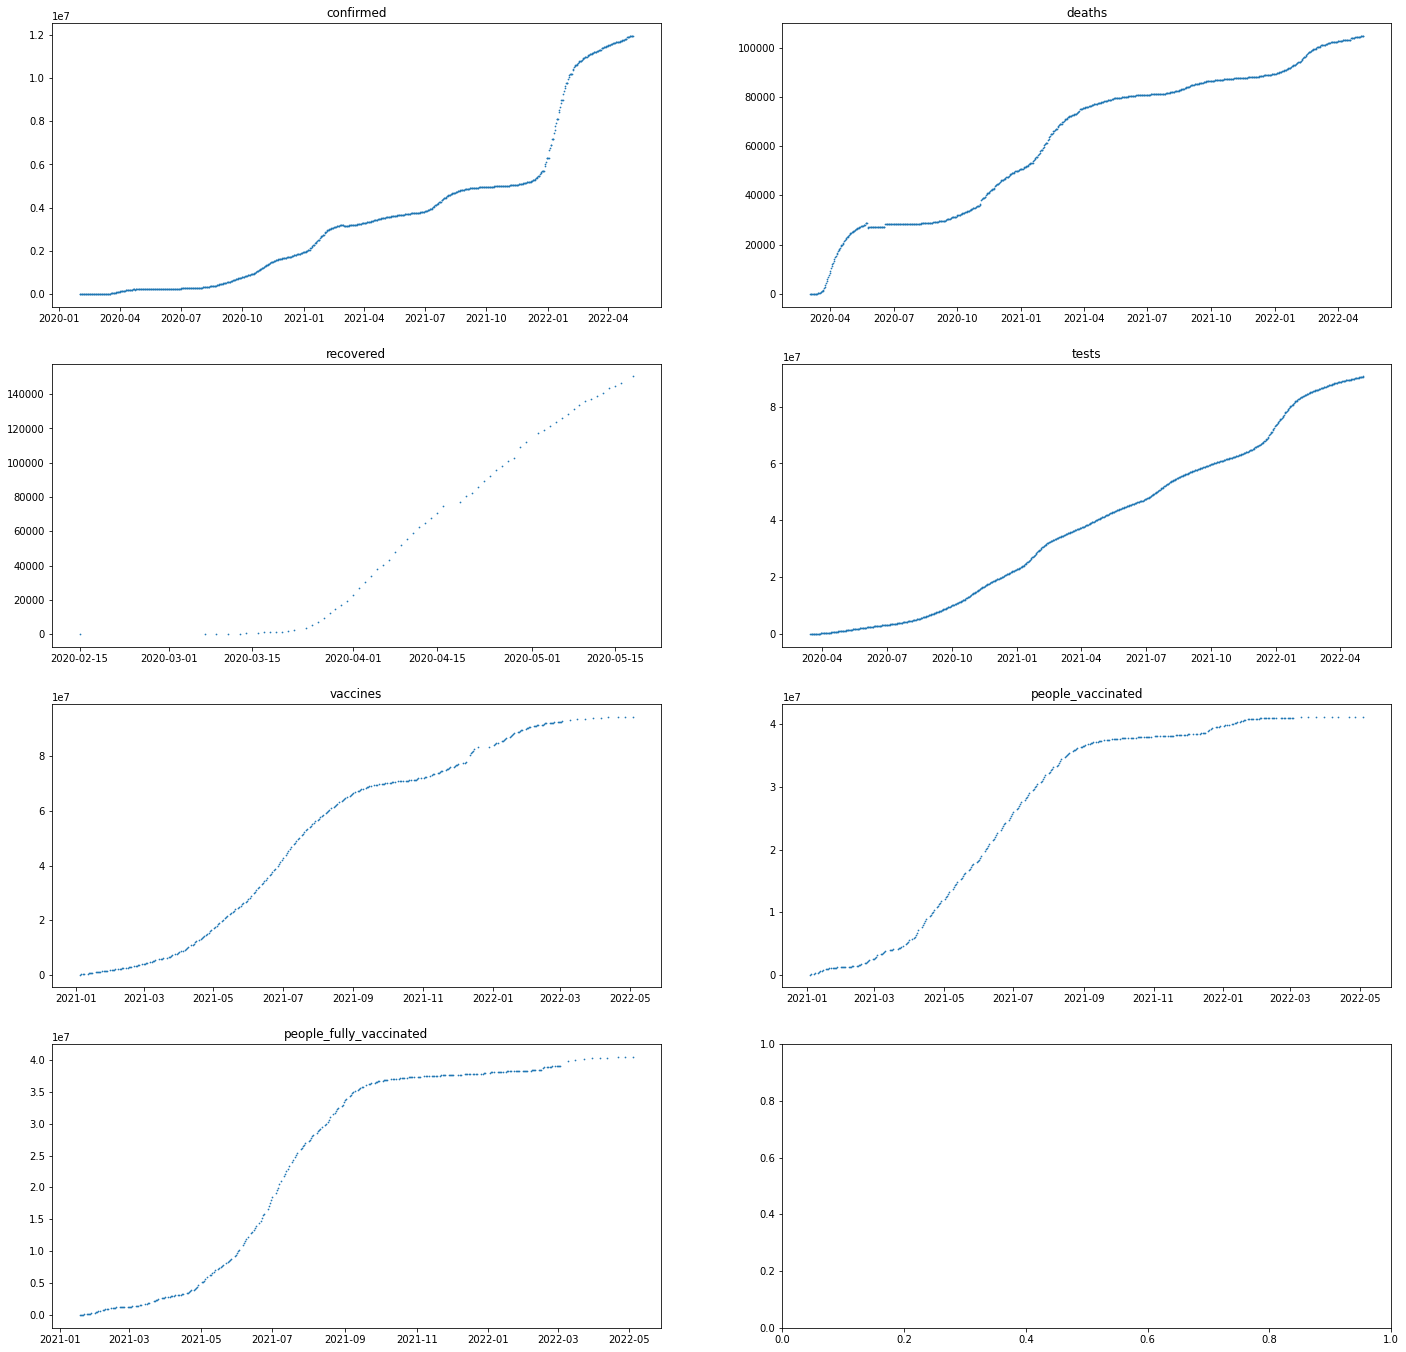

In [23]:
fig, ax = plt.subplots(4, 2, figsize=(24,24))

cols = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated']

for it, col in enumerate(cols):
    i = it // 2
    j = it % 2
    ax[i, j].scatter(spain['date'], spain[col], s=0.5)
    ax[i, j].set_title(col)

plt.show()

In [24]:
spain = spain.drop('recovered', axis=1)

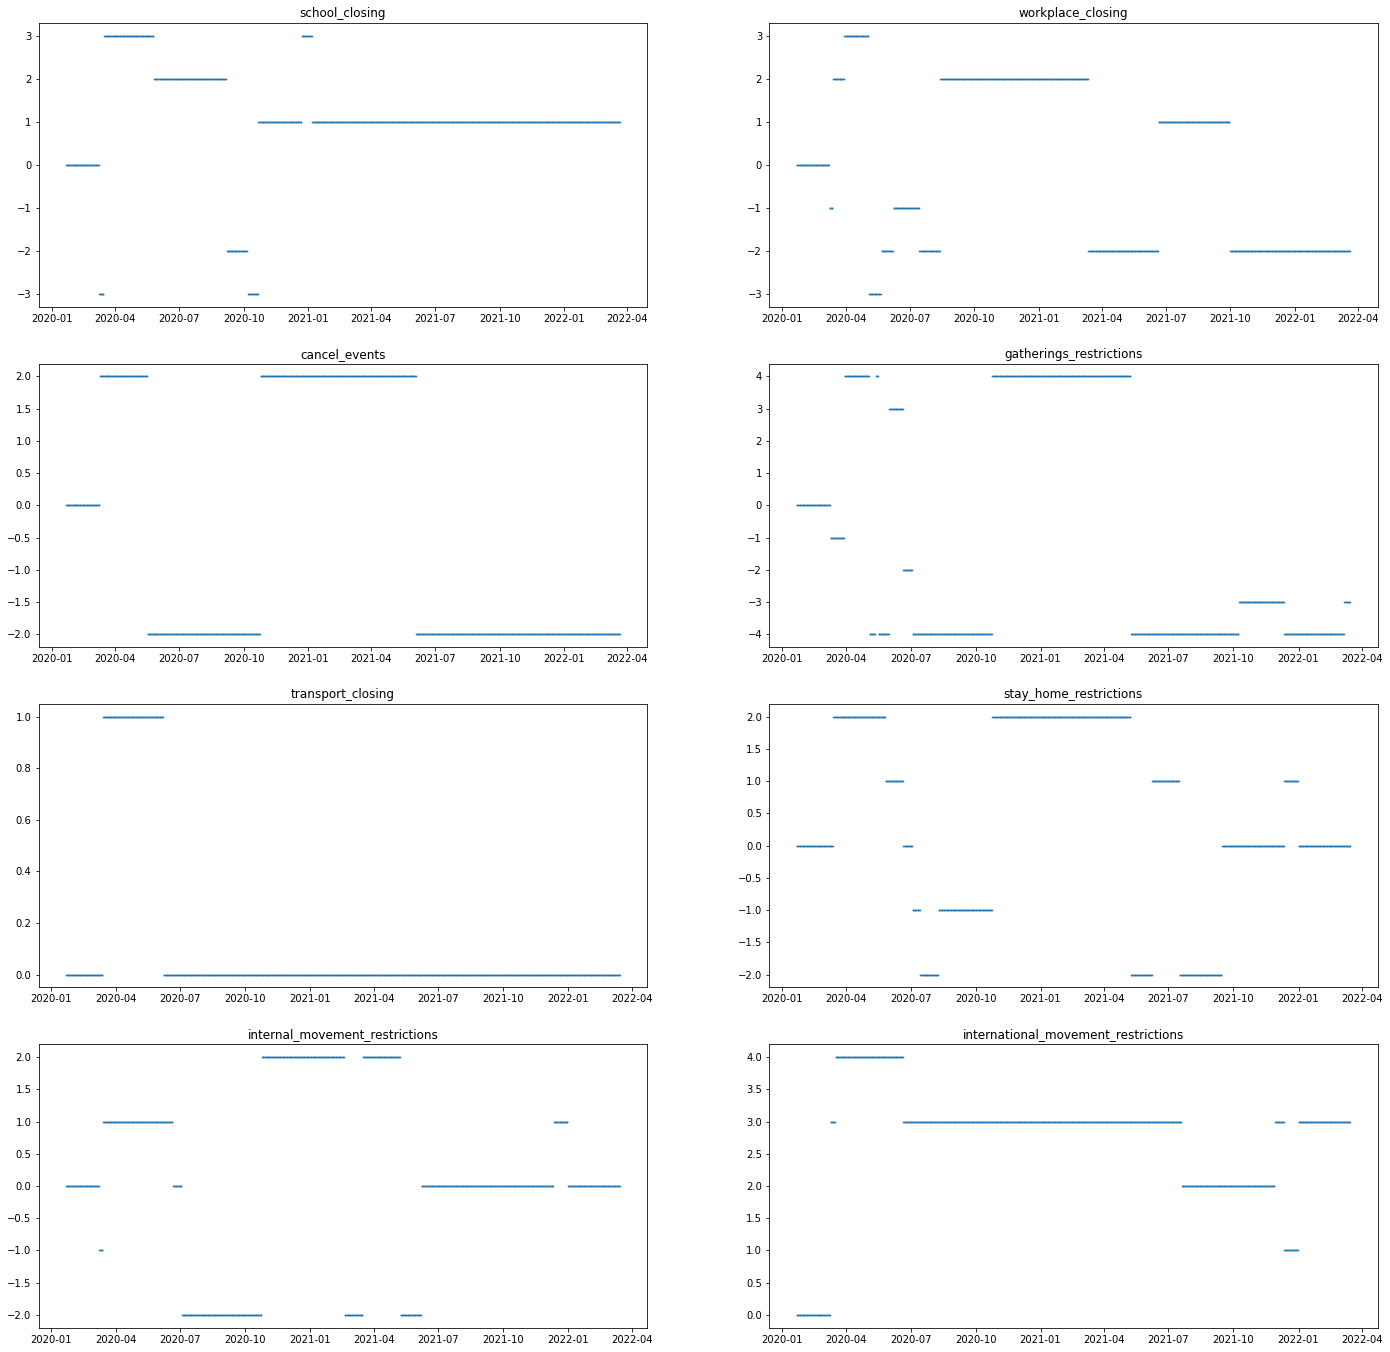

In [25]:
fig, ax = plt.subplots(4, 2, figsize=(24,24))

cols = ['school_closing', 'workplace_closing', 'cancel_events', 'gatherings_restrictions',
       'transport_closing', 'stay_home_restrictions', 'internal_movement_restrictions',
        'international_movement_restrictions']

for it, col in enumerate(cols):
    i = it // 2
    j = it % 2
    ax[i, j].scatter(spain['date'], spain[col], s=0.5)
    ax[i, j].set_title(col)

plt.show()

In [26]:
spain.columns

Index(['date', 'confirmed', 'deaths', 'tests', 'vaccines', 'people_vaccinated',
       'people_fully_vaccinated', 'school_closing', 'workplace_closing',
       'cancel_events', 'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'population'],
      dtype='object')

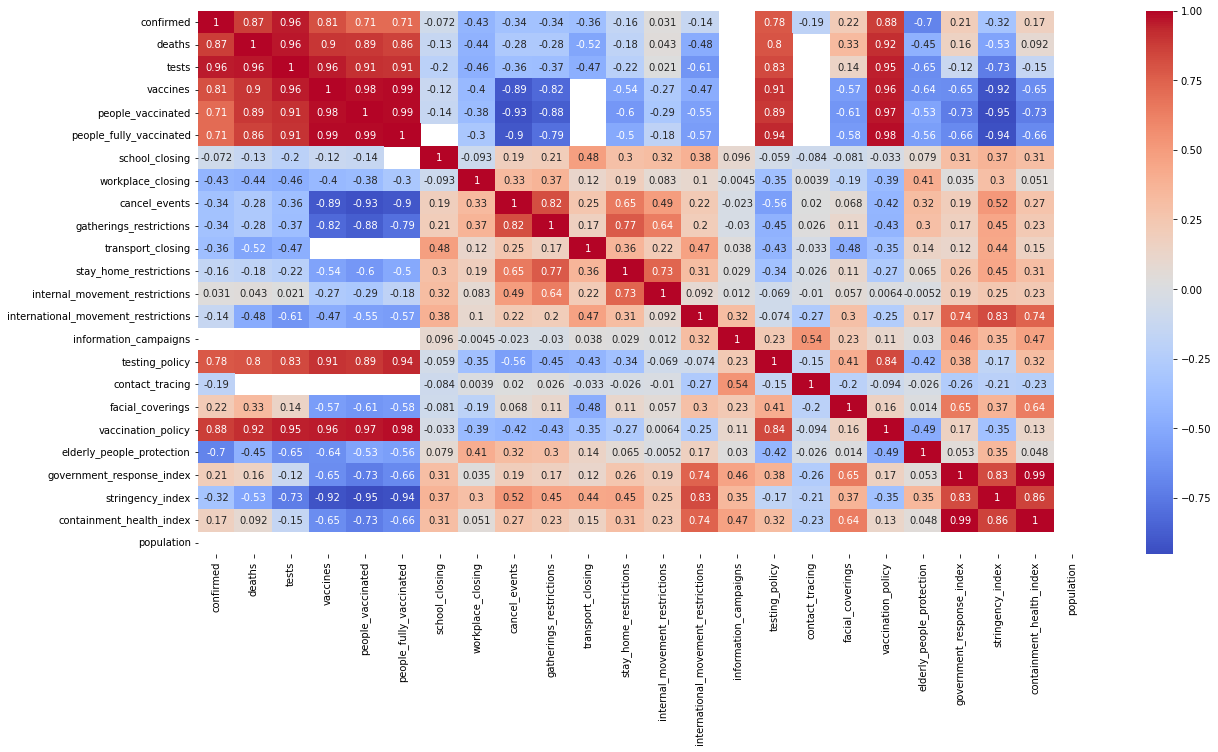

In [27]:
figure = plt.figure(figsize=(20, 10))
sns.heatmap(spain.corr(), annot=True, cmap= 'coolwarm')
plt.show()

In [28]:
world.tail(100)

,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,school_closing,workplace_closing,...,testing_policy,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,administrative_area_level_1,population
138329,2022-01-29,9039.0,71.0,NaN,96548.0,68773.0,26626.0,26007.0,1.0,1.0,...,3.0,2.0,3.0,5.0,1.0,58.33,47.22,59.52,Liechtenstein,37910.0
138330,2022-01-30,9133.0,71.0,8475.0,96769.0,68773.0,26626.0,26007.0,1.0,1.0,...,3.0,2.0,3.0,5.0,1.0,58.33,47.22,59.52,Liechtenstein,37910.0
138331,2022-01-31,9279.0,71.0,8609.0,97065.0,69084.0,26645.0,26042.0,1.0,1.0,...,3.0,2.0,3.0,5.0,1.0,58.33,47.22,59.52,Liechtenstein,37910.0
138332,2022-02-01,9402.0,71.0,NaN,97447.0,69352.0,26676.0,26070.0,1.0,1.0,...,3.0,2.0,3.0,5.0,1.0,58.33,47.22,59.52,Liechtenstein,37910.0
138333,2022-02-02,9515.0,71.0,8826.0,97798.0,69352.0,26676.0,26071.0,1.0,1.0,...,3.0,2.0,3.0,5.0,1.0,58.33,47.22,59.52,Liechtenstein,37910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138424,2022-05-04,NaN,NaN,17070.0,NaN,NaN,NaN,NaN,0.0,1.0,...,3.0,0.0,1.0,5.0,1.0,35.42,23.15,33.33,Liechtenstein,37910.0
138425,2022-05-05,NaN,NaN,17072.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Liechtenstein,37910.0
138426,2022-05-06,NaN,NaN,17093.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Liechtenstein,37910.0
138427,2022-05-07,NaN,NaN,17100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Liechtenstein,37910.0


Braki danych (Spain):
- Zauważyłem, że wszystkie braki danych dla kolumn opisujących restrykcje i antycovidową politykę kraju występują od dnia 16/03/2022. W moim odczuciu może to być spowodowane przez kilka rzeczy:
    - powszechnie zauważalny trend do zmniejszania obostrzeń w tym czasie
    - dane za ten okres mogły nie zostać jeszcze odpowiednio przetworzone i wprowadzone do zbioru z Covid Data Hub
    - dane mogą nie być już tak pieczołowicie gromadzone jak to miało miejsce wcześniej

  Biorąc pod uwagę powyższe czynniki oraz fakt, że omawiane braki stanowią niewiele ponad 5% całego zestawu, a zbadanie ich wpływu na liczbę zachorowań i zgonów uważam za istotne, zdecydowałem się usunąć obserwacje z okresu po 16/03/2022.



- vaccines, people_vaccinated, people_fully_vaccinated: braki głównie w weekendy (na pewno?)
- restrykcje: braki danych pod koniec, tak samo dla wszystkich restrykcji. Można usunąć, lub zastąpić ostatnią znaną wartością?

In [29]:
idx = spain[spain['date'] == '2022-03-16'].index
row_num = spain.index.get_loc(idx[0])
spain_cut = spain.drop(spain.index[row_num:])

print(spain.shape, spain_cut.shape)

(838, 25) (784, 25)


In [30]:
spain_cut_nulls = 100 * spain_cut.isnull().sum() / spain_cut.shape[0]
spain_nulls = 100 * spain.isnull().sum() / spain.shape[0]

pd.DataFrame({
    'spain': spain_nulls,
    'spain_cut': spain_cut_nulls
})

,spain,spain_cut
date,0.000000,0.000000
confirmed,1.193317,1.275510
deaths,4.892601,5.229592
tests,6.801909,6.760204
vaccines,64.558473,63.137755
people_vaccinated,64.081146,62.627551
people_fully_vaccinated,64.916468,63.520408
school_closing,5.727924,0.000000
workplace_closing,5.727924,0.000000
cancel_events,5.727924,0.000000


In [31]:
spain = spain_cut

Powyższa tabela potwierdza, że po usunięciu obserwacji od 16/03/2022 udało się całkowicie wyeliminować braki danych dla wspomnianych kolumn. Przyjrzyjmy się ponownie wykresom:

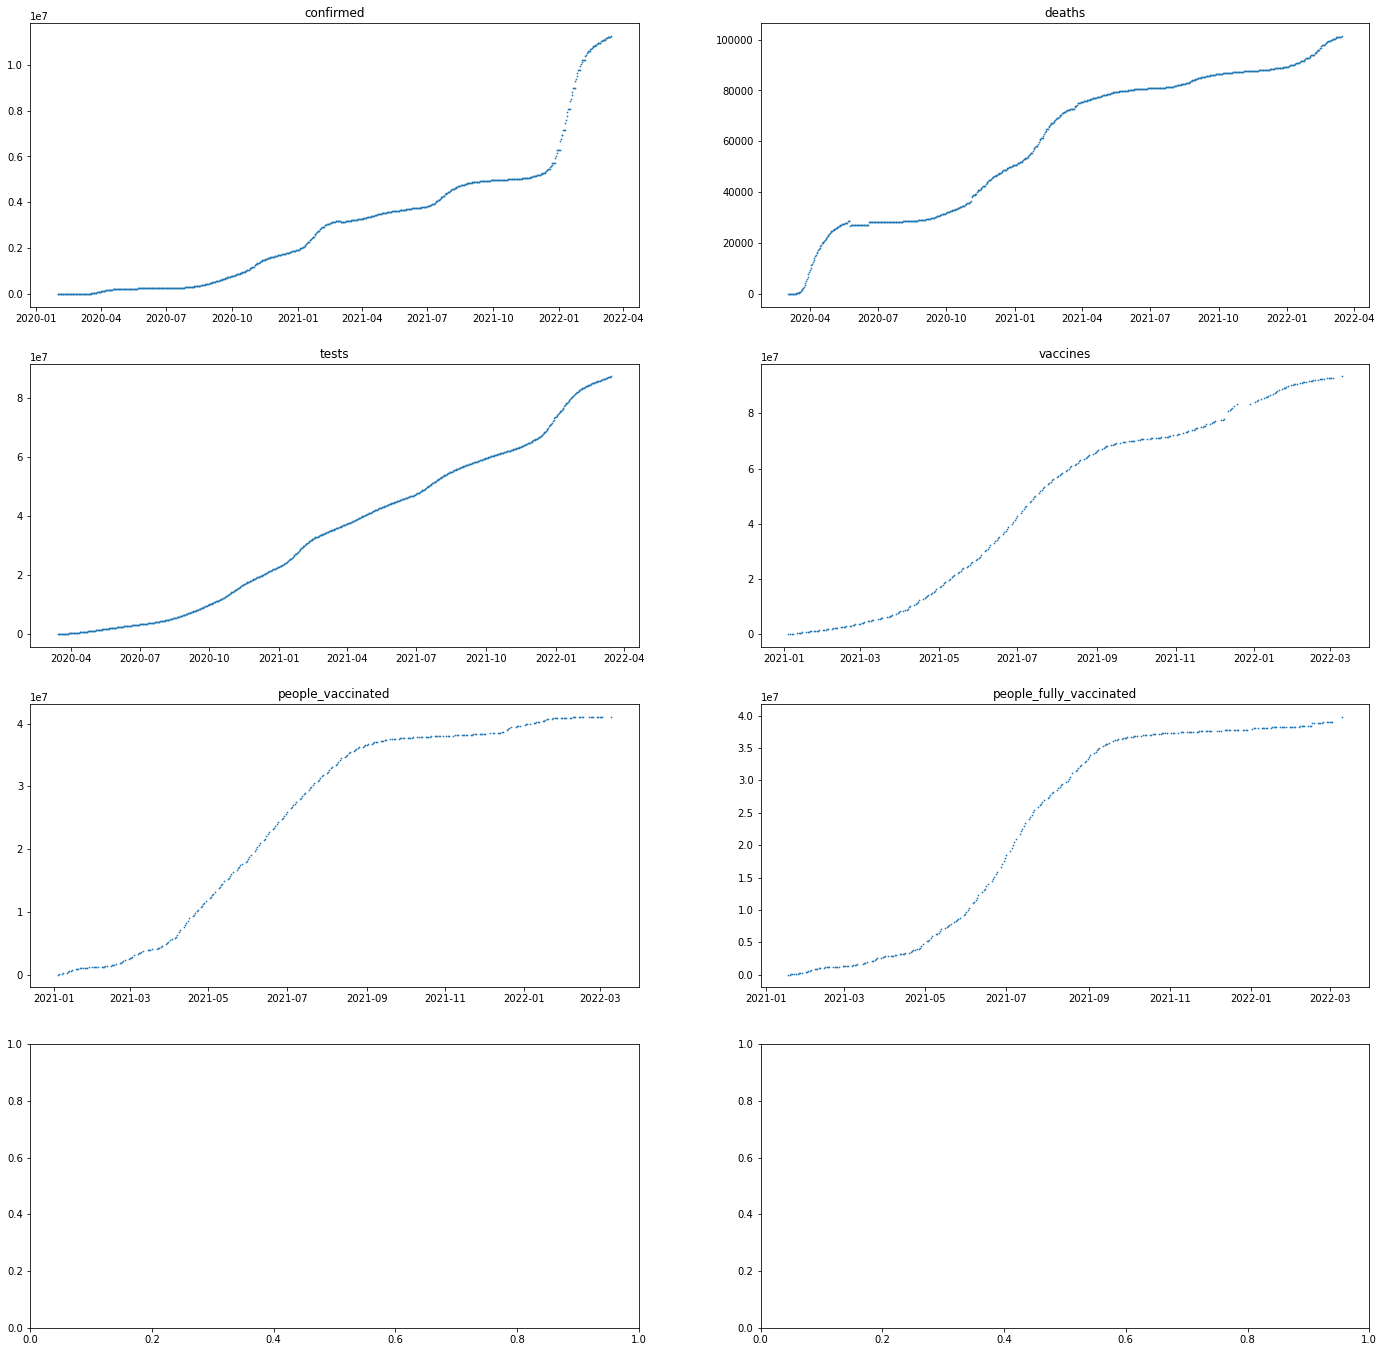

In [32]:
fig, ax = plt.subplots(4, 2, figsize=(24,24))

cols = [i for i in spain.columns if spain[i].isnull().any()]

for it, col in enumerate(cols):
    i = it // 2
    j = it % 2
    ax[i, j].scatter(spain['date'], spain[col], s=0.5)
    ax[i, j].set_title(col)

plt.show()

Dla danych z kolumny deaths możemy zaobserwować dziwne zjawisko. W okresie letnich miesięcy 2020 mamy fragment gdzie całkowita liczba odnotowanych zgonów spada w czasie. Jest to niemożliwe, ponieważ mówimy o parametrze skumulowanym, a więc takim który może tylko rosnąć. Sprawdzimy, czy podobne sytuacje występują dla innych skumulowanych parametrów.

In [33]:
columns_with_error = []
for col in cols:
    a = np.array(spain[col].dropna())
    if not np.all(a[:-1] <= a[1:]):
        columns_with_error.append(col)
print(columns_with_error)

['confirmed', 'deaths']


Widać, że opisany problem występuje w kolumnach 'confirmed' i 'deaths'. Dla pozostałych zmiennych skumulowanych, kolejne wartości są zawsze nie mniejsze od poprzednich. Pozostaje pytanie, jak postąpić z powyższym błędem. Zdecydowałem, że w miejscach gdzie wartości zaczynają spadać, zastąpię je ostatnim poprawnym odczytem.


In [34]:
for col in columns_with_error:
    a = np.array(spain[col])
    for i in range(1, spain.shape[0]):
        if a[i] < a[i-1]:
            a[i] = a[i-1]
    spain[col] = a

Sprawdzamy czy błąd został naprawiony.

In [35]:
columns_with_error = []
for col in cols:
    a = np.array(spain[col].dropna())
    if not np.all(a[:-1] <= a[1:]):
        columns_with_error.append(col)
print(columns_with_error)

[]


Jak widać pozbyliśmy się błędu. Zajmiemy się teraz brakami danych dla pozostałych cech. Duże braki danych występują dla zmiennych odpowiadających za szczepienia, ale wynika to z faktu że nie były one dostępne przez początkowy okres pandemii. W takiej sytuacji, naturalne wydaje się zastąpienie ich zerami, do momentu wystąpienia pierwszej wartości w tych kolumnach. Tak samo postępujemy dla kolumn 'confirmed' i 'deaths'.

In [36]:
cols = ['vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'confirmed', 'deaths']
spain[cols] = spain[cols].interpolate('zero', fill_value=0, limit_direction='backward')

In [37]:
100 * spain.isnull().sum() / spain.shape[0]

date                                   0.000000
confirmed                              0.000000
deaths                                 0.000000
tests                                  6.760204
vaccines                               0.637755
people_vaccinated                      0.637755
people_fully_vaccinated                0.637755
school_closing                         0.000000
workplace_closing                      0.000000
cancel_events                          0.000000
gatherings_restrictions                0.000000
transport_closing                      0.000000
stay_home_restrictions                 0.000000
internal_movement_restrictions         0.000000
international_movement_restrictions    0.000000
information_campaigns                  0.000000
testing_policy                         0.000000
contact_tracing                        0.000000
facial_coverings                       0.000000
vaccination_policy                     0.000000
elderly_people_protection              0

In [38]:
spain[cols + ['date']].tail(7)

,vaccines,people_vaccinated,people_fully_vaccinated,confirmed,deaths,date
777,92774397.0,41083791.0,39103590.0,11181510.0,100992.0,2022-03-09
778,93346088.0,41089269.0,39845453.0,11204125.0,101077.0,2022-03-10
779,NaN,NaN,NaN,11223974.0,101135.0,2022-03-11
780,NaN,NaN,NaN,11223974.0,101135.0,2022-03-12
781,NaN,NaN,NaN,11223974.0,101135.0,2022-03-13
782,NaN,NaN,NaN,11223974.0,101135.0,2022-03-14
783,NaN,NaN,NaN,11260040.0,101416.0,2022-03-15


Udało się znacznie ograniczyć braki, zostały tylko w 5 ostatnich wierszach dla danych o szczepionkach. Dla tych wartości przeprowadzimy prostą interpolację liniową, zakładając że tempo szczepień utrzymywało się w tym czasie. Takie przybliżenie może być obarczone pewnym błędem, ale jest na pewno lepszym rozwiązaniem niż uzupełnianie braków ostatnią znaną wartością, ponieważ opierałoby się to na przesłankach że ludzie nagle całkowicie przestali się szczepić, co nie jest prawdą. Aby wziąć pod uwagę trend szczepień w interesujacym nas okresie, a nie z całego przebiegu pandemii, zawężymy liczbę wierszy używanych do interpolacji do dwóch miesięcy.

In [39]:
spain.loc[-60:, cols] = spain.loc[-60:, cols].interpolate('linear')

In [40]:
i = spain.tests.first_valid_index()
ratio = spain['tests'][i:i+14]/spain['confirmed'][i:i+14]
ratio

53    0.808284
54    1.544257
55    2.301924
56    2.862329
57    3.047264
58    3.474375
59    3.355403
60    3.385776
61    3.279656
62    3.440867
63    3.255014
64    3.230627
65    3.235001
66    3.183109
dtype: float64

W przypadku testów, policzyliśmy stosunek liczby wykonany testów do potwierdzonych przypadków w pierwszych 2 tygodniach kiedy mamy dane z testów. Widzimy że pierwsza wartość (0.808) musi być błędna, ponieważ sugerowałaby że wykonano mniej testów niż potwierdzono przypadków. Wartość z 55. wiersza (2.30) jest już jak najbardziej możliwa i tej wartości użyjemy do uzupełnienia braków z początku. Zakładamy więc, że stosunek wykonywanych testów do liczby potwierdzonych przypadków był względnie stały przez pierwsze dni pandemii.

In [41]:
spain.loc[:i+4,'tests'] = (spain['confirmed'][:i+5] * ratio[i+2]).astype(int)

In [42]:
spain.head(60)

,date,confirmed,deaths,tests,vaccines,people_vaccinated,people_fully_vaccinated,school_closing,workplace_closing,cancel_events,...,information_campaigns,testing_policy,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,population
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,46796540.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,46796540.0
2,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
4,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
5,2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
6,2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
7,2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
8,2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
9,2020-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,2.0,0.0,0.0,0.0,14.58,11.11,16.67,46796540.0


In [43]:
spain.isnull().sum()

date                                   0
confirmed                              0
deaths                                 0
tests                                  0
vaccines                               0
people_vaccinated                      0
people_fully_vaccinated                0
school_closing                         0
workplace_closing                      0
cancel_events                          0
gatherings_restrictions                0
transport_closing                      0
stay_home_restrictions                 0
internal_movement_restrictions         0
international_movement_restrictions    0
information_campaigns                  0
testing_policy                         0
contact_tracing                        0
facial_coverings                       0
vaccination_policy                     0
elderly_people_protection              0
government_response_index              0
stringency_index                       0
containment_health_index               0
population      

Pozbyliśmy się braków danych dla Hiszpanii.

## DANE GLOBALNE

In [196]:
world.head()

,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,school_closing,workplace_closing,...,testing_policy,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,administrative_area_level_1,population
119977,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saint Lucia,181889.0
119978,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saint Lucia,181889.0
119979,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saint Lucia,181889.0
119980,2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saint Lucia,181889.0
119981,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saint Lucia,181889.0


Jest pewna grupa krajów dla których występują braki danych w kolumnie testów dochodzące do 100%. Dlatego niemożliwe jest przeprowadzenie sensownej analizy na całym zbiorze danych. Jeśli nie wiemy ile testów zostało wykonanych, pozostałe dane są również mało wiarygodne. Dedycuduję się na wyrzucenenie ze zbioru krajów które mają braki danych w kolumnie testów powyżej 75%.

In [197]:
test_nan = world['tests'].isna().groupby(world['administrative_area_level_1']).mean()
test_nan

administrative_area_level_1
Afghanistan             0.996420
Albania                 0.156325
Algeria                 0.998807
American Samoa          1.000000
Andorra                 0.909308
                          ...   
Virgin Islands, U.S.    1.000000
Wallis and Futuna       1.000000
Yemen                   0.997613
Zambia                  0.106205
Zimbabwe                0.211217
Name: tests, Length: 236, dtype: float64

In [198]:
good_testers = list(test_nan[test_nan < 0.5].index)
len(good_testers)

102

In [199]:
world = world.drop('recovered', axis=1)

In [200]:
world = world[world['administrative_area_level_1'].isin(good_testers)]

In [201]:
100 * world.isnull().sum() / world.shape[0]

date                                    0.000000
confirmed                               4.329548
deaths                                  6.931303
tests                                  15.345262
vaccines                               61.388155
people_vaccinated                      62.592518
people_fully_vaccinated                64.321495
school_closing                          8.878178
workplace_closing                       8.919626
cancel_events                           8.921995
gatherings_restrictions                 8.929100
transport_closing                       8.930284
stay_home_restrictions                  8.929100
internal_movement_restrictions          8.907784
international_movement_restrictions     8.919626
information_campaigns                   8.923179
testing_policy                          8.917258
contact_tracing                         8.910152
facial_coverings                        8.929100
vaccination_policy                      8.924363
elderly_people_prote

In [202]:
world_by_countries = [y for x, y in world.groupby('administrative_area_level_1', as_index=False)]
len(world_by_countries)

102

Podzieliliśmy zbiór danych na mniejsze data frames, gdzie każdy z nich odpowiada danym z jednego kraju. Wykonamy teraz dalsze kroki procesu czyszczenia danych podobnie jak miało to miejsce w przypadku danych z Hiszpanii, iterując po kolejnych krajach.

#### Uzupełnienie potwierdzonych przypadków, śmierci i danych o szczepionkach zerami, z początku pandemii

In [203]:
cols = ['vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'confirmed', 'deaths']
for country_df in world_by_countries:
    country_df[cols] = country_df[cols].interpolate('zero', fill_value=0, limit_direction='backward')

#### Pozbycie się ewentualnych błędów w monotoniczności dla danych skumulowanych

In [204]:
for country_df in world_by_countries:
    columns_with_error = []

    for col in cols:
        a = np.array(country_df[col].dropna())
        if not np.all(a[:-1] <= a[1:]):
            columns_with_error.append(col)

    for col in columns_with_error:
        a = np.array(country_df[col])
        for i in range(1, country_df.shape[0]):
            if a[i] < a[i-1]:
                a[i] = a[i-1]
        country_df[col] = a

Sprawdzamy ile zostało braków, usuwamy z dalszych rozważań państwa które mają wysoki współczynnik braków danych pomimo przeprowadzonych wcześniej operacji:

In [205]:
countries_to_delete = []
for i, country_df in enumerate(world_by_countries):
    nan_ratio = (country_df.isnull().sum() / country_df.shape[0]).mean()
    if nan_ratio > 0.6:
        countries_to_delete.append(i)

In [206]:
countries_to_delete.sort()
for index in sorted(countries_to_delete, reverse=True):
    del world_by_countries[index]

#### Interpolacja wartości skumulowanych

In [207]:
cols = ['vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'confirmed', 'deaths']

for i, country_df in enumerate(world_by_countries):
    country_df[cols] = country_df[cols].interpolate('linear')
    world_by_countries[i] = country_df

In [240]:
cols = ['vaccines', 'people_vaccinated', 'people_fully_vaccinated']
countries_to_delete = []
for i, country_df in enumerate(world_by_countries):
    vaccine_nulls_ratio = (100 * country_df[cols].isnull().sum() / country_df.shape[0]).sum() / len(cols)
    if vaccine_nulls_ratio == 100:
        countries_to_delete.append(i)
print(countries_to_delete)

for idx in reversed(countries_to_delete):
    del world_by_countries[idx]

[33, 68]


#### Uzupełnienie testów z początku pandemii odpowiednim współczynnikiem oraz interpolacja pozostałych brakujących wartości

In [241]:
for k, country_df in enumerate(world_by_countries):
    # Uzupełnienie z początku pandemii
    country_df = country_df.reset_index(drop=True)
    i = country_df.tests.first_valid_index()
    a = country_df['tests'][i:i+14]
    b = country_df['confirmed'][i:i+14]
    ratio = np.divide(a, b, out=np.zeros_like(a), where=b!=0 )
    mean_ratio = max(ratio.mean(), 1)
    country_df.loc[:i,'tests'] = (country_df['confirmed'][:i+1] * mean_ratio).astype(int)
    # Interpolacja pozostałych wartości
    country_df['tests'] = country_df['tests'].interpolate('linear')

    world_by_countries[k] = country_df

In [242]:
first_null= []
for country_df in world_by_countries:
    nulls = country_df[country_df['cancel_events'].isnull()].index.tolist()
    if nulls:
        first_null.append(nulls[0])
print(np.median(first_null), np.mean(first_null))
print(world_by_countries[0].shape)

807.5 786.3928571428571
(820, 26)


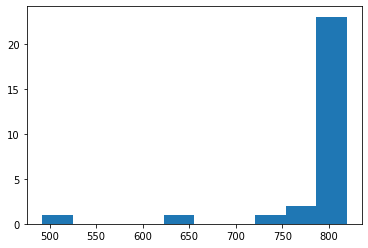

In [243]:
plt.hist(first_null)
plt.show()

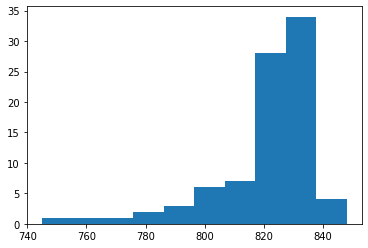

In [229]:
first_null = np.array(first_null)
first_null = first_null[first_null > 700]
plt.hist(first_null)
plt.show()

W zdecydowanej większości przypadków braki danych dla kolumn opisujących restrykcje występują dla ostatnich tygodni, tak samo jak w przypadku Hiszpanii. Wyniki analizy przedstawiłem na histogramie. Robię tak, aby nie usunąć za dużo obserwacji, a jedynie tyle aby pozbyć się największej części braków, a przy tym zachować stałą rozdzielczość obserwacji co jeden dzień (nie usuwać obserwacji ze środka). Po przeanalizowaniu histogramu widać, że zdecydowana większość państw przestaje raportować w okolicy 815-820 dnia, co dobrze obrazuje obliczona wartość średnia. Dlatego nie będziemy brać pod uwagę obserwacji po tym dniu, a pozostałe (wcześniejsze) uzupełnimy ostatnią znaną wartością.

In [257]:
restriction_cols = world_by_countries[0].columns[7:-2]
for i, country_df in enumerate(world_by_countries):
    df_cut = country_df.drop(country_df.index[int(np.mean(first_null)):])
    df_cut[restriction_cols] = df_cut[restriction_cols].ffill()
    world_by_countries[i] = df_cut

#### Ponowne złączenie w jeden dataframe

In [258]:
world = pd.concat(world_by_countries)

In [259]:
100 * world.isnull().sum() / world.shape[0]

date                                   0.0
confirmed                              0.0
deaths                                 0.0
tests                                  0.0
vaccines                               0.0
people_vaccinated                      0.0
people_fully_vaccinated                0.0
school_closing                         0.0
workplace_closing                      0.0
cancel_events                          0.0
gatherings_restrictions                0.0
transport_closing                      0.0
stay_home_restrictions                 0.0
internal_movement_restrictions         0.0
international_movement_restrictions    0.0
information_campaigns                  0.0
testing_policy                         0.0
contact_tracing                        0.0
facial_coverings                       0.0
vaccination_policy                     0.0
elderly_people_protection              0.0
government_response_index              0.0
stringency_index                       0.0
containment